In [2]:
!pip install xgboost

In [3]:
import pandas as pd
import numpy as np 
import json
import joblib
import sagemaker
import boto3
import os
from time import gmtime, strftime, sleep
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sagemaker.experiments.run import Run, load_run

sagemaker.__version__

'2.132.0'

In [4]:
target_col = "DC_POWER"

In [5]:
session = sagemaker.Session()
sm = session.sagemaker_client

In [6]:
#read data and save it in pandas dataframe
df = pd.read_csv("data/combined_plant.csv")

In [7]:
df.head()

,DATE_TIME,SOURCE_KEY,DC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,1IF53ai7Xc0U56Y,0.0,0.0,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,3PZuoBAID5Wc2HD,0.0,0.0,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,7JYdWkrLSPkdwr4,0.0,0.0,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,McdE0feGgRqW7Ca,0.0,0.0,25.184316,22.857507,0.0


## Create an experiment

In [8]:
experiment_name = f"Solar-energy-experiment-model2-{strftime('%d-%H-%M-%S', gmtime())}"

## Feature engineering

In [9]:
df.drop(['SOURCE_KEY', 'DATE_TIME'], axis=1)

,DC_POWER,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,0.0,0.0,25.184316,22.857507,0.0
1,0.0,0.0,25.184316,22.857507,0.0
2,0.0,0.0,25.184316,22.857507,0.0
3,0.0,0.0,25.184316,22.857507,0.0
4,0.0,0.0,25.184316,22.857507,0.0
...,...,...,...,...,...
136467,0.0,4157.0,23.202871,22.535908,0.0
136468,0.0,3931.0,23.202871,22.535908,0.0
136469,0.0,4322.0,23.202871,22.535908,0.0
136470,0.0,4218.0,23.202871,22.535908,0.0


In [10]:
# Shuffle and split the dataset
train_data, validation_data, test_data = np.split(
    df.sample(frac=1, random_state=1729),
    [int(0.7 * len(df)), int(0.9 * len(df))],
)

print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

Data split > train:(95530, 7) | validation:(27294, 7) | test:(13648, 7)


In [11]:
file_source = "EFS"
file_name = "combined_plant.csv"
input_path = "./data" 
output_path = "./data"

In [12]:
train_data.to_csv(os.path.join(output_path, "train.csv"), index=False, header=False)
validation_data.to_csv(os.path.join(output_path, "validation.csv"), index=False, header=False)
test_data.to_csv(os.path.join(output_path, "test.csv"), index=False, header=False)
    

## Model training and validation

In [13]:
train_features = train_data.drop(target_col, axis=1)
train_label = pd.DataFrame(train_data[target_col])
train_features_numeric = train_features.drop(['DATE_TIME', 'SOURCE_KEY'], axis=1)

In [14]:
dtrain = xgb.DMatrix(train_features_numeric, label=train_label)

In [15]:
hyperparams = {
                "eta": 0.01,
                "booster": 'gblinear',
                "objective":'reg:squarederror',
                "base_score" : 0.5,
                "eval_metric" :'rmse',
                "random_state" : 567
              }

num_boost_round = 300
nfold = 3
early_stopping_rounds = 10

In [16]:
cv_results = xgb.cv(
    params=hyperparams,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    nfold=nfold,
    early_stopping_rounds=early_stopping_rounds,
    metrics=["rmse"],
    seed=10,
)

In [17]:
metrics_data = {
    "Regressor_metrics": {
        "validation:rmse": {
            "value": cv_results.iloc[-1]["test-rmse-mean"],
            "standard_deviation": cv_results.iloc[-1]["test-rmse-std"]
        },
        "train:rmse": {
            "value": cv_results.iloc[-1]["train-rmse-mean"],
            "standard_deviation": cv_results.iloc[-1]["train-rmse-std"]
        },
    }
}

In [18]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3599.292118,3.988145,3599.285406,8.489614
1,3546.230520,3.785751,3546.224375,8.559702
2,3496.421464,3.637436,3496.416130,8.565250
3,3449.601927,3.450638,3449.597367,8.600326
4,3405.641817,3.273465,3405.638128,8.617553
...,...,...,...,...
295,2432.045770,2.018126,2432.159220,2.184883
296,2431.744490,2.018769,2431.858055,2.193797
297,2431.445765,2.019400,2431.559447,2.202692
298,2431.149571,2.020016,2431.263365,2.211566


In [19]:
test_features = test_data.drop(target_col, axis=1)
test_label = pd.DataFrame(test_data[target_col])
test_features_numeric = test_features.drop(['DATE_TIME', 'SOURCE_KEY'], axis=1)
dtest = xgb.DMatrix(test_features_numeric, label=test_label)

In [20]:
run_suffix = strftime('%Y-%m-%M-%S', gmtime())

with Run(experiment_name=experiment_name,
         run_name=f"feature-engineering-{run_suffix}",
         run_display_name="feature-engineering",
         sagemaker_session=session) as run:
    run.log_parameters(
        {
            "train": 0.7,
            "validate": 0.2,
            "test": 0.1
        }
    )
    # Log input dataset metadata and output
    run.log_artifact(name="combined-plant-dataset", value="./data/combined_plant.csv", media_type="text/csv", is_output=False)
    run.log_artifact(name="train-csv", value="./data/train.csv", media_type="text/csv")
    run.log_artifact(name="validation-csv", value="./data/validation.csv", media_type="text/csv")
    run.log_artifact(name="test-csv", value="./data/test.csv", media_type="text/csv")

In [21]:
# in the production code you need to use the unique ids
run_suffix = strftime('%Y-%m-%M-%S', gmtime())

# Train the model for different eta values
for i, d in enumerate([0.01, .05, .1, .5, 0.7,0.8, 0.9]):
    hyperparams["eta"] = d
    
    print(f"Fit estimator with eta={d}")
    run_name = f"training-{i}-{run_suffix}"
    
    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name=f"eta-{i+1}",
             sagemaker_session=session) as run:
        # Train the model
        model = (
            xgb.train(
                params=hyperparams, 
                dtrain=dtrain, 
                evals = [(dtrain,'train'), (dtest,'eval')], 
                num_boost_round=num_boost_round, 
                early_stopping_rounds=early_stopping_rounds, 
                verbose_eval = 0
            )
        )

        # Calculate metrics
        test_rmse = np.sqrt(mean_squared_error(test_label, model.predict(dtest)))
        train_rmse = np.sqrt(mean_squared_error(train_label, model.predict(dtrain)))

        # test_rmse = np.sqrt(mean_squared_error((test_label, y_pred=model.predict(dtest))))
        # train_rmse = np.sqrt(mean_squared_error((train_label, y_pred=model.predict(dtrain))))
        
        # Log metrics to the run
        run.log_parameters(hyperparams)
        run.log_metric(name="test_rmse", value = test_rmse, step=i+1)
        run.log_metric(name="train_rmse", value = train_rmse, step=i+1)

        # time.sleep(8) # wait until resource tags are propagated to the run

        print(f"Test rmse: {test_rmse:.4f} | Train rmse: {train_rmse:.4f}")

Fit estimator with eta=0.01
Test rmse: 2415.4670 | Train rmse: 2430.8787
Fit estimator with eta=0.05
Test rmse: 2358.3553 | Train rmse: 2373.6642
Fit estimator with eta=0.1
Test rmse: 2330.6972 | Train rmse: 2345.8904
Fit estimator with eta=0.5
Test rmse: 2139.9672 | Train rmse: 2154.6761
Fit estimator with eta=0.7
Test rmse: 2063.2592 | Train rmse: 2077.8498
Fit estimator with eta=0.8
Test rmse: 2029.8126 | Train rmse: 2044.3297
Fit estimator with eta=0.9
Test rmse: 2000.2047 | Train rmse: 2014.6121


In [22]:
# in the production code you need to use the unique ids
run_suffix = strftime('%Y-%m-%M-%S', gmtime())

# Train the model for different base_score values
for i, d in enumerate([ .05, .1, .5, 0.6,0.7]):
    hyperparams["base_score"] = d
    
    print(f"Fit estimator with base_score={d}")
    run_name = f"training-{i}-{run_suffix}"
    
    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name=f"eta-{i+1}",
             sagemaker_session=session) as run:
        # Train the model
        model = (
            xgb.train(
                params=hyperparams, 
                dtrain=dtrain, 
                evals = [(dtrain,'train'), (dtest,'eval')], 
                num_boost_round=num_boost_round, 
                early_stopping_rounds=early_stopping_rounds, 
                verbose_eval = 0
            )
        )

        # Calculate metrics
        test_rmse = np.sqrt(mean_squared_error(test_label, model.predict(dtest)))
        train_rmse = np.sqrt(mean_squared_error(train_label, model.predict(dtrain)))

        # test_rmse = np.sqrt(mean_squared_error((test_label, y_pred=model.predict(dtest))))
        # train_rmse = np.sqrt(mean_squared_error((train_label, y_pred=model.predict(dtrain))))
        
        # Log metrics to the run
        run.log_parameters(hyperparams)
        run.log_metric(name="test_rmse", value = test_rmse, step=i+1)
        run.log_metric(name="train_rmse", value = train_rmse, step=i+1)

        # time.sleep(8) # wait until resource tags are propagated to the run

        print(f"Test rmse: {test_rmse:.4f} | Train rmse: {train_rmse:.4f}")

Fit estimator with base_score=0.05
Test rmse: 1999.6744 | Train rmse: 2014.0798
Fit estimator with base_score=0.1
Test rmse: 2000.7337 | Train rmse: 2015.1434
Fit estimator with base_score=0.5
Test rmse: 1999.5249 | Train rmse: 2013.9297
Fit estimator with base_score=0.6
Test rmse: 2000.7600 | Train rmse: 2015.1698
Fit estimator with base_score=0.7
Test rmse: 2000.5259 | Train rmse: 2014.9347


In [23]:
import datetime
import pandas as pd

df = pd.read_csv("data/combined_plant.csv")
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
df["DATE"] = df["DATE_TIME"].dt.date
df["TIME"] = pd.to_datetime(df["DATE_TIME"]).dt.strftime('%H:%M:%S')
df_plot = df[df['DATE'] == datetime.date(2020, 5, 19)]
df_plot=df.loc[100:1900]
timeplot=df_plot["TIME"]
df_plot.drop(['SOURCE_KEY', 'DATE_TIME', 'DATE'], axis=1)
plot_features = df_plot.drop('DC_POWER', axis=1)
plot_label = pd.DataFrame(df_plot['DC_POWER'])
plot_features_numeric = plot_features.drop(['DATE_TIME', 'SOURCE_KEY','DATE','TIME'], axis=1)
dplot = xgb.DMatrix(plot_features_numeric, label=plot_label)
predict=model.predict(dplot)
dc=df_plot["DC_POWER"]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


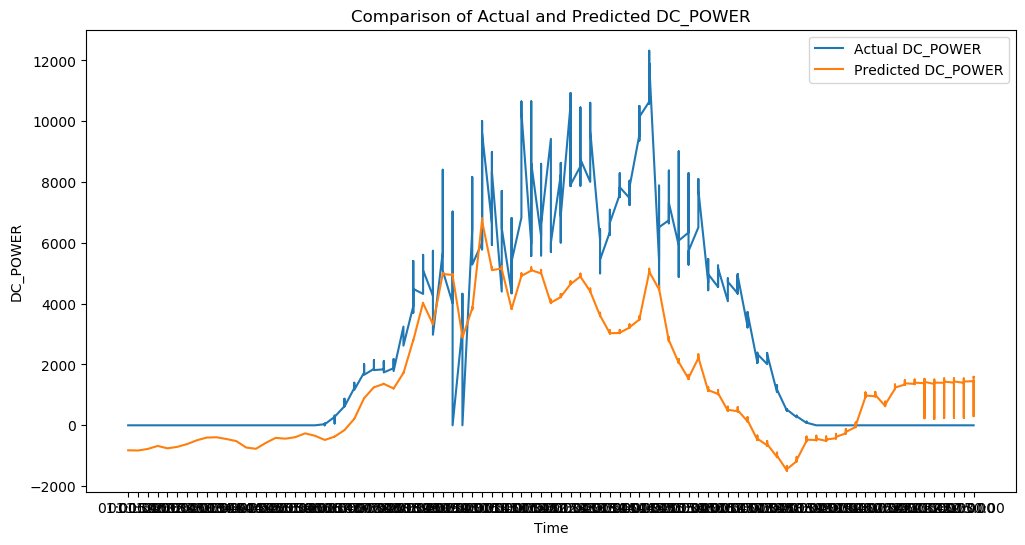

In [24]:
import matplotlib.pyplot as plt
#time_str = [t.strftime('%H:%M:%S') for t in time]
plt.figure(figsize=(12, 6))
plt.plot(timeplot, dc, label='Actual DC_POWER')
plt.plot(timeplot, predict, label='Predicted DC_POWER')
plt.xlabel('Time')
plt.ylabel('DC_POWER')
plt.title('Comparison of Actual and Predicted DC_POWER')
plt.legend()

plt.show()

In [25]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>